In [1]:
import matplotlib.pyplot as plt
from collections import Counter
from configs import *
from fetch_data import *
from features_extraction import *
from data_shuffling_split import *
from data_preprocess import *
from modeling import *

In [2]:
strat_train_set = read_csv("train/strat_train_set.csv")
strat_train_set.head()

Number of instances in the file are:  449033


,id,dialect,dialect_l_encoded,text
0,1056552188082716800,LY,8,توا دوشه الكلاسيكو شن بيتمها وشن بيسكتهم وشن ب...
1,891734969202114560,SY,15,حسابشخصي في احلي من الشحاطه 😂
2,1110565179257954432,SD,14,حسابشخصي موهبه والله 😂 اوع تحاول تطورها تقوم م...
3,1172817955270340608,LB,7,حسابشخصي حسابشخصي 😂 انا صرلي عشر سنين مش مجدده...
4,293253217821790208,QA,12,احلي شعور تكون باجازه وتقوم من الصبح وتمر ع ال...


In [3]:
texts_list = list(strat_train_set['text'])
print("Before Tokenization : \n", texts_list[:3])
tokenized_texts = tokenize_using_nltk_TreebankWordTokenizer(texts_list)
print("After Tokenization : \n", tokenized_texts[:3])

Before Tokenization : 
 ['توا دوشه الكلاسيكو شن بيتمها وشن بيسكتهم وشن بي عصبنها هالدواره', 'حسابشخصي في احلي من الشحاطه 😂 ', 'حسابشخصي موهبه والله 😂 اوع تحاول تطورها تقوم ما تصحي']
After Tokenization : 
 [['توا', 'دوشه', 'الكلاسيكو', 'شن', 'بيتمها', 'وشن', 'بيسكتهم', 'وشن', 'بي', 'عصبنها', 'هالدواره'], ['حسابشخصي', 'في', 'احلي', 'من', 'الشحاطه', '😂'], ['حسابشخصي', 'موهبه', 'والله', '😂', 'اوع', 'تحاول', 'تطورها', 'تقوم', 'ما', 'تصحي']]


# Curse of Dimensional & sparsity

Tasks like **Computer Vision** or **Natural Language Processing** run to problem called **Curse of Dimensional**, and as we have here NLP classification problem, the number of instance are semi-large, but this not the point, the point is what we dealing with is text language, and the language are free of grammar, ritch of vocabulary and others.

So to handle like these problems we need to extract features from the text, the old or classical way is using BOW (Bag of Words), and this approach run to the problem of **Curse of Dimensionality** as we will have number of features related to the unique words in our data. Not just that most of these features are zeros, what is we called sparse matrix.

Beside of that, this matrix we will get from that approach represent the text not the word itself, so there is no similarity between words and other problem.

# Word2Vec

From what we have of these problem we moved to another approach related to the word representation.

Word2vec is numerical representation of dense vector for the word semantics of meaning, including the implies meaning of the word. So we can use these word representation in our text as we will see.

But to train Word2Vec and got a pretty good result of word representation, it first require massive data millions of text document, and second to wait for a while for your model to train. So we use the idea of transfer learning, and use some of the pre trained Arabic Word2Vec models and download it to use in our task. 

**Check for more information about the models we used:** [AraVec](https://www.sciencedirect.com/science/article/pii/S1877050917321749)



# Build Matrix of Text

Any ML or DL model require specific number of features (input) to dealing with, but what we have here with word2vec is word representation. So how it works for text ?

We will build a matrix for each text, but we need to limit the number of words in each text, because we can not train the model with different number of words in text.

# Note !

We can take the maximum number of words in the longest text, but maybe for some documents its has thousand of words, so we use the graph below and other helpful method to get reasonable length.

In [4]:
# Get how many words inside each text after tokenization
num_of_words_in_each_text = [len(text) for text in tokenized_texts]
max_len = max(num_of_words_in_each_text)
print("The max length is: ", max_len)
num_of_words_in_each_text[:10]

The max length is:  94


[11, 6, 10, 26, 19, 31, 7, 6, 6, 10]

The number of keys before removing are:  86
The number of keys after removing some of them are:  50


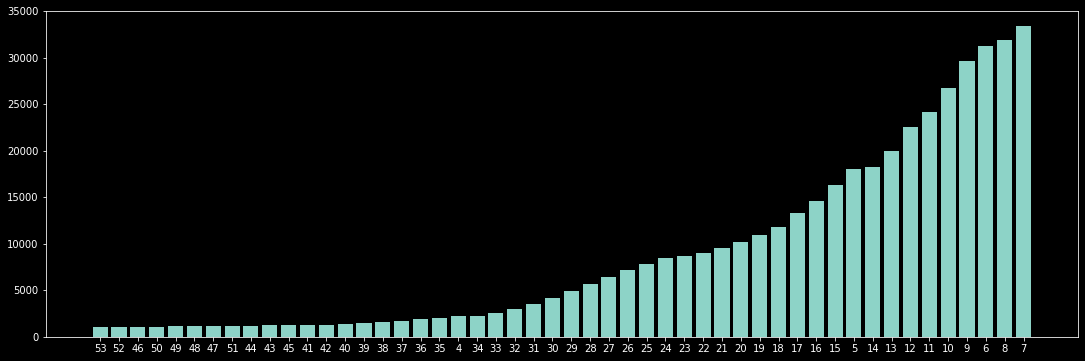

In [5]:
# count how many times these value repeated and sort them
new_dicts = get_keys_that_val_gr_than_num(num_of_words_in_each_text, 1000)
keys = list(new_dicts.keys())
values = list(new_dicts.values())
plt.style.use('dark_background')
fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.bar(range(len(new_dicts)), values, tick_label=keys)
plt.show()

In [6]:
word_to_vec_model = load_word2vec_model("models/word2vec/rezk_unigram_CBOW_model/train_word2vec_cbow__window_3_min_count_300")

In [7]:
texts_check = tokenized_texts[:50000]
number_of_features = 300
max_len_str = 32

In [8]:
embedding_matrix = ML_text_to_matrix_using_word2vec(word_to_vec_model, texts_check, number_of_features, max_len_str)

The shape of matrix (50000, 9600)


In [9]:
type(embedding_matrix)

numpy.ndarray

In [10]:
y_train = np.array(strat_train_set['dialect_l_encoded']).reshape(-1,1)

In [11]:
y_train.shape

(449033, 1)

In [12]:
keras_model(embedding_matrix, y_train, 10, 32, 1)

/home/abdelrahman/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


MemoryError: Unable to allocate 1.61 GiB for an array with shape (45000, 9600) and data type float32

In [ ]:
# logreg_model = LogisticRegression(C=2.0, multi_class='ovr', penalty='l2', solver='liblinear')
# logreg_model.fit(train_embedding_matrix, target_train)

# model_predict_train__test_data(logreg_model, train_embedding_matrix, target_train,
#                               test_embedding_matrix, target_test)

In [ ]:
model.save('models/sgd_keras_model.h5')